In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

from notebook_client.notebook_client import NotebookClient

In [2]:
nc = NotebookClient()
nc.initialize_producers_manager_connection()
nc.initialize_sampler_manager_connection()

In [3]:
producer_pid = nc.start_streaming('in_topic', { 'locations': '-74,40,-73,41' })

In [4]:
reservoir_size = 5
limit = 20
nc.start_sampling('in_topic', 'out_topic', reservoir_size, limit)

In [5]:
nc.streaming_status(producer_pid)

'running'

In [6]:
nc.sampling_status()

'running'

In [14]:
nc.stop_streaming(producer_pid)

'stopped'

In [17]:
from kafka import KafkaConsumer

consumer = KafkaConsumer('out_topic', bootstrap_servers='kafka')
consumer.topics()
partition = consumer.assignment().pop()

In [22]:
consumer.seek_to_end()

In [23]:
end = consumer.position(partition)
consumer.seek(partition, end - reservoir_size)

In [24]:
consumer.position(partition)

0

In [25]:
get_value = lambda c: c.__next__().value.decode('utf-8')
data = [get_value(consumer) for i in range(reservoir_size)]

In [26]:
parsed_data = list(map(lambda x: json.loads(x), data))

In [27]:
df = pd.DataFrame.from_records(data=parsed_data)
df['created_at'] = pd.to_datetime(df['created_at'])
df.index = df.created_at
del df['created_at']

In [28]:
df

,text,user_favourites_count,user_friends_count,user_id,user_name,user_verified
created_at,,,,,,
2017-07-26 19:46:15,"See our latest #NewYork, NY #job and click to ...",0,326,20832061,NYC Sales Jobs,False
2017-07-26 19:46:20,Just posted a photo @ Lower East Side https://...,539,787,750370596,BK 1,False
2017-07-26 19:46:26,Este domingo llegamos a sahara_cafe con el dal...,471,1622,28223933,El Klan Perfecto,False
2017-07-26 19:46:35,What do you call a self-absorbed lobster?\n\nA...,3972,131,843528421284233220,"wil, son.",False
2017-07-26 19:46:36,Well firing Mueller will be the nail in his lo...,43151,25916,739844197935644672,Andrew Wortman,False


In [29]:
df.describe()

,user_favourites_count,user_friends_count,user_id
count,5.000000,5.00000,5.000000e+00
mean,9626.600000,5756.40000,3.166745e+17
std,18807.849486,11284.19294,4.351712e+17
min,0.000000,131.00000,2.083206e+07
25%,471.000000,326.00000,2.822393e+07
50%,539.000000,787.00000,7.503706e+08
75%,3972.000000,1622.00000,7.398442e+17
max,43151.000000,25916.00000,8.435284e+17


In [30]:
#text_lengths = df.text.map(lambda x: len(x.split(' ')))
text_lengths = df.text.map(len)

In [31]:
text_lengths.describe()

count      5.00000
mean      91.80000
std       30.19437
min       61.00000
25%       63.00000
50%      100.00000
75%      102.00000
max      133.00000
Name: text, dtype: float64

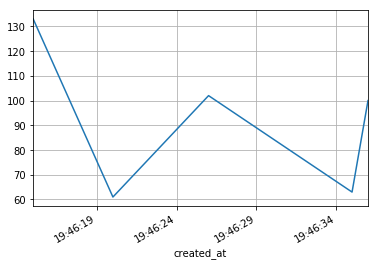

In [32]:
text_lengths.plot(grid=True)
plt.show()